# Individualized speed zones

In this article we will show you, how you can calculate the distance spent in individualized speed thresholds from GPS raw data. Our data was generated using Polar Team Pro. Individualized speed thresholds were calculated based on Rago et al. (2020). In this notebook we are using the programming language python.

## Let's get started ...

First we need to import a few softwarepackages. Pandas helps us to create a dataframe, in which we can organise the collected GPS data. Numpy is a mathematical library allowing us to perform mathematical operations with our data (addition, subtraction, etc.). Matplotlib is a graphical package that helps to visualize some data.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

Before we go deeper into the code itself, you can go ahead and run the code once...

Loop beginnt...
.
..
...


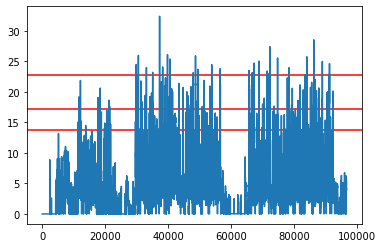

In [5]:
Tbl = pd.read_excel('MAS+MSS.xlsx')
os.chdir('data')
Files=os.listdir()

def getSpeedAndDistance (File): # import of rawdata, computing to arrays containing speeds and distances
    data=pd.read_csv(File)
    v=np.array(data['Geschwindigkeit [km/h]']) # velocity in km/h
    s=np.array(data['Distanz [m]']) # cumulative distance
    ds=np.gradient(s) # distance per time unit
    return v, ds

def getThreshold (Tbl,ID): # importing MAS & MSS, calculating speed zones in arrays
    MAS=np.float64(Tbl.MAS[ID])
    MSS=np.float64(Tbl.MSS[ID])
    LowThresh=np.array([0 , 0.8*MAS , MAS , (MSS - MAS) * 0.29 + MAS])
    return LowThresh

def MetreInZones(LowThresh, v, ds): # allocating distances into zones, outputing metres covered in Zones
    HighThresh=np.append(LowThresh[1:],1e4)
    Metrezone = np.array([])
    for count in range (0, len(LowThresh)):
        e = (v >= LowThresh[count]) & (v < HighThresh[count])
        distancesInZone = e * ds
        Metrezone = np.append(Metrezone, np.sum(distancesInZone))
    return Metrezone

for File in Files: # calling the function for all Players defined in dictionary
    v,ds=getSpeedAndDistance(File)
    Thresh=getThreshold(Tbl,0)
    MetreInZones(Thresh,v,ds)

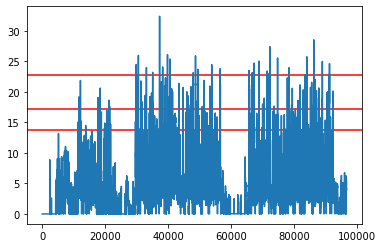

In the graph you can see the plotted speed in blue and the tresholds between the individualized speed zones in red. We can already see, that our player spents most of the session in the lowest zone. 

The four speed zones are set as follows:
Zone 1: < 80% Maximal Aerobic Speed (MAS)
Zone 2: 80% MAS - 100% MAS
Zone 3: 100% MAS - 29% Anaerobic Speed Reserve (ASR)
Zone 4: > 29% ASR

## Let's dive into the code


1  def MeterIndividualisierteZonen (GPSRohdatenpfad, SpielerID, ZonenDatenPfad):
2 
3     print('Loop beginnt...')
4     Spieler = {}
5     allspeeds = np.array([])
6     alldistances = np.array([0])
7     Dateiname_new = GPSRohdatenpfad + str(SpielerID) + '.xls'
8     f = pd.ExcelFile(Dateiname_new)
9     for gut in range(1, len(f.sheet_names)+1):
10        Spieler[gut] = pd.read_excel(Dateiname_new, sheet_name='Page ' + str(gut))
11        allspeeds = np.append(allspeeds, Spieler[gut]['Geschwindigkeit [km/h]'])
12        alldistances = np.append(alldistances, Spieler[gut]['Distanz [m]'])
 
At the end our function will return us the distance spent in each zone for one player. Line 1 shows us the definition of our function. We need to insert the path of where our GPS raw data is saved, as well as the ID of our player and the path of the file, in which we stored the values for the maximal aerobic speed and the maximal sprint speed. This file looks as follows:

In [4]:
print(pd.read_excel('D:\Master -SEHP- 01.02.21\semester 4\projekt robin\MAS+MSS.xlsx'))

   Spieler _ ID   MAS   MSS
0             1  16.2  35.4
1             2  17.2  36.4
2             3  18.2  37.4
3             4  19.2  38.4
4             5  20.2  39.4


For the purpose of this demonstration, we saved the data of five players in this file. 

It becomes a little more interesting in the lines 9 - 12. We need this for loop to import all the GPS rawdata. The rawdata output from Polar Team Pro saves only 36000 datapoints per sheet (with 10Hz GPS, this is equivalent to a duration of 1h). Therefore we need to import the different sheets of the excel file separately and append each sheet to the respective array.
This leaves us with the follwing arrays:

In [232]:
print('Speeds: ', allspeeds)
print('Distances: ', alldistances)

Speeds:  [0.    0.    0.    ... 0.058 0.058 0.058]
Distances:  [    0.             0.             0.         ... 15356.09960938
 15356.09960938 15356.09960938]


The problem we are now facing, is that the distance covered is reported cumulatively in the GPS raw data export. This can be seen in the larger number at the end of array containing the Distances. Therefore we need to loop trough the array alldistances to calculate the differences between two back-to-back values. This is achieved in the next lines of code:

13    alldistances_diff = np.array([])   
14        for gut in range (0, len(alldistances)-1):
15            alldistances_diff = np.append(alldistances_diff, alldistances[gut+1] - alldistances[gut])

This for loop creates the array alldistances_diff, which contains the distance covered since the last measured datapoint. In the following graph we can see the differences between the cumulative array and differences we just calculated.

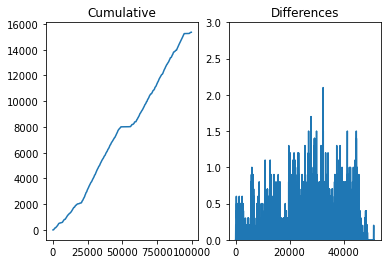

In [256]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Cumulative')
ax1.plot(alldistances)
ax2.set_ylim([0,3])
ax2.set_title('Differences')
ax2.plot(alldistances_diff)

After we have now imported the GPS rawdata into our program and appended it to the respective array, we need to calculate the individualized speed zones...

16 DatenZonen = pd.read_excel(ZonenDatenPfad)
17    SpielerZonen1temp = np.array([])
18    for count in range (1,3):
19        SpielerZonen1temp = np.append(SpielerZonen1temp, DatenZonen.loc[SpielerID-1][count])
20    a = 0.8 * SpielerZonen1temp[0]
21    b = SpielerZonen1temp[0]
22    c = (SpielerZonen1temp[1] - SpielerZonen1temp[0]) * 0.29 + SpielerZonen1temp[0]
23    Spielerzonen1 = np.array([0])
24    Spielerzonen2 = np.array([10000.4])
25    ZonenList = [a,b,c]
26    alpha = 0
27    for count in ZonenList:
28        Spielerzonen1 = np.append(Spielerzonen1, count)
29        Spielerzonen2 = np.insert(Spielerzonen2, 0+alpha, count)
30        alpha = alpha + 1

First the excelfile, in which we stored MAS and MSS is imported into the programm (line 16). In the following for loop (line 18) MAS and MSS is appended to an array. Line 20 - 22 calculates the thresholds for the individualized speed zones (a = Zone 1 upper limit, b = Zone 2 upper limit and c = Zone 3 upper limit/Zone 4 lower limit)
The individualized speed zones are then stored in two arrays each:

In [260]:
print(Spielerzonen1)
print(Spielerzonen2)

[ 0.    13.76  17.2   22.768]
[   13.76     17.2      22.768 10000.4  ]


Lastly, we use these two arrays to allocate the distances to arrays based on their speed. In the for loop (line 32) the programme over the date for each speed zone. At the end of the loop (line 36) all distances in the array are summed. Line 37 then returns the distance spent in the four different individually defined speed zones.

31    Meterzone = {}
32        for count in range (0, len(Spielerzonen1)):
33            e = allspeeds >= Spielerzonen1[count] 
34            f = allspeeds <= Spielerzonen2[count]
35            logicalvector = (e*f) * alldistances_diff
36            Meterzone[count+1] = np.sum(logicalvector)
37        return Meterzone[1], Meterzone[2], Meterzone[3], Meterzone[4]

In [261]:
print(Meterzone[1],Meterzone[2],Meterzone[3],Meterzone[4])

5336.300994873047 835.2973327636719 541.8027954101562 278.398681640625


## How to call the function

One final step is remaining to get our desired output. We need to call the function. We need to insert the ID of all the players that participated into the dictionary 'Players' (line 38).

38    Players = [2]

We can then call the function by using a for loop to iterate over all the players we included in the dictionary.
In the calling of the function we also need to include the path of the location, in which we saved our GPS rawdata and of the file in which we saved MAS and MSS (line 40+41).

39    for count in Players:    
40        MeterIndividualisierteZonen('D:\Master -SEHP- 01.02.21\semester 4\projekt robin\Rohdaten\Rohdaten_Spieler',           41        count,'D:\Master -SEHP- 01.02.21\semester 4\projekt robin\MAS+MSS.xlsx')

# Summary

This notebook provides a practical guideline on how to individualize speed thresholds based on GPS raw data. Our individualized speed thresholds are set according to Rago et al. (2020). 